In [1]:
# help("modules")

In [21]:
import pandas as pd
import numpy as np 
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.preprocessing import OnehotTransactions
from sklearn.preprocessing import LabelEncoder

Importing The data and checking a few columns to check if data is all correct.

In [6]:
bakery_data=pd.read_csv("BreadBasket_DMS.csv")

bakery_data['Date Time']=bakery_data['Date']+" "+bakery_data['Time']

bakery_data=bakery_data.drop(['Date','Time'],axis=1)
print("Top 5 rows of data")

print(bakery_data.head(25))

print("Bottom 5 rows of data")

print(bakery_data.tail(5))

print(len(bakery_data))

Top 5 rows of data
    Transaction           Item            Date Time
0             1          Bread  2016-10-30 09:58:11
1             2   Scandinavian  2016-10-30 10:05:34
2             2   Scandinavian  2016-10-30 10:05:34
3             3  Hot chocolate  2016-10-30 10:07:57
4             3            Jam  2016-10-30 10:07:57
5             3        Cookies  2016-10-30 10:07:57
6             4         Muffin  2016-10-30 10:08:41
7             5         Coffee  2016-10-30 10:13:03
8             5         Pastry  2016-10-30 10:13:03
9             5          Bread  2016-10-30 10:13:03
10            6      Medialuna  2016-10-30 10:16:55
11            6         Pastry  2016-10-30 10:16:55
12            6         Muffin  2016-10-30 10:16:55
13            7      Medialuna  2016-10-30 10:19:12
14            7         Pastry  2016-10-30 10:19:12
15            7         Coffee  2016-10-30 10:19:12
16            7            Tea  2016-10-30 10:19:12
17            8         Pastry  2016-10-30 10

In [4]:
bakery_data.dtypes
#Can Probably ease the memory requirement and speed up processing by formatting datatypes properly.

# bakery_data['Date']=pd.to_datetime(bakery_data['Date'])
# bakery_data['Time']=pd.to_datetime(bakery_data['Time'])
bakery_data['Date Time']=pd.to_datetime(bakery_data['Date Time'])
bakery_data.dtypes

#Types are Proper.Can move Forward.Object dtype is string.

Transaction             int64
Item                   object
Date Time      datetime64[ns]
dtype: object

In [5]:
#Frequency Distribution of Items.

bakery_data['Item'].unique()

len(bakery_data['Item'].unique())

#95 Unique Items.Must me a big bakery.

print(bakery_data['Item'].value_counts())
print(bakery_data['Item'].value_counts().sum())
# Most Popular Ordered item is Coffee which is no surprise.I am surprised though that hot chocolate is 
# ordered very less though

Coffee                           5471
Bread                            3325
Tea                              1435
Cake                             1025
Pastry                            856
NONE                              786
Sandwich                          771
Medialuna                         616
Hot chocolate                     590
Cookies                           540
Brownie                           379
Farm House                        374
Muffin                            370
Alfajores                         369
Juice                             369
Soup                              342
Scone                             327
Toast                             318
Scandinavian                      277
Truffles                          193
Coke                              185
Spanish Brunch                    172
Fudge                             159
Baguette                          152
Jam                               149
Tiffin                            146
Mineral wate

In [6]:
# Mandatory Nan Check

bakery_data.isnull().sum()

# No empty values found so dataset is clean and processed properly.

Transaction    0
Item           0
Date Time      0
dtype: int64

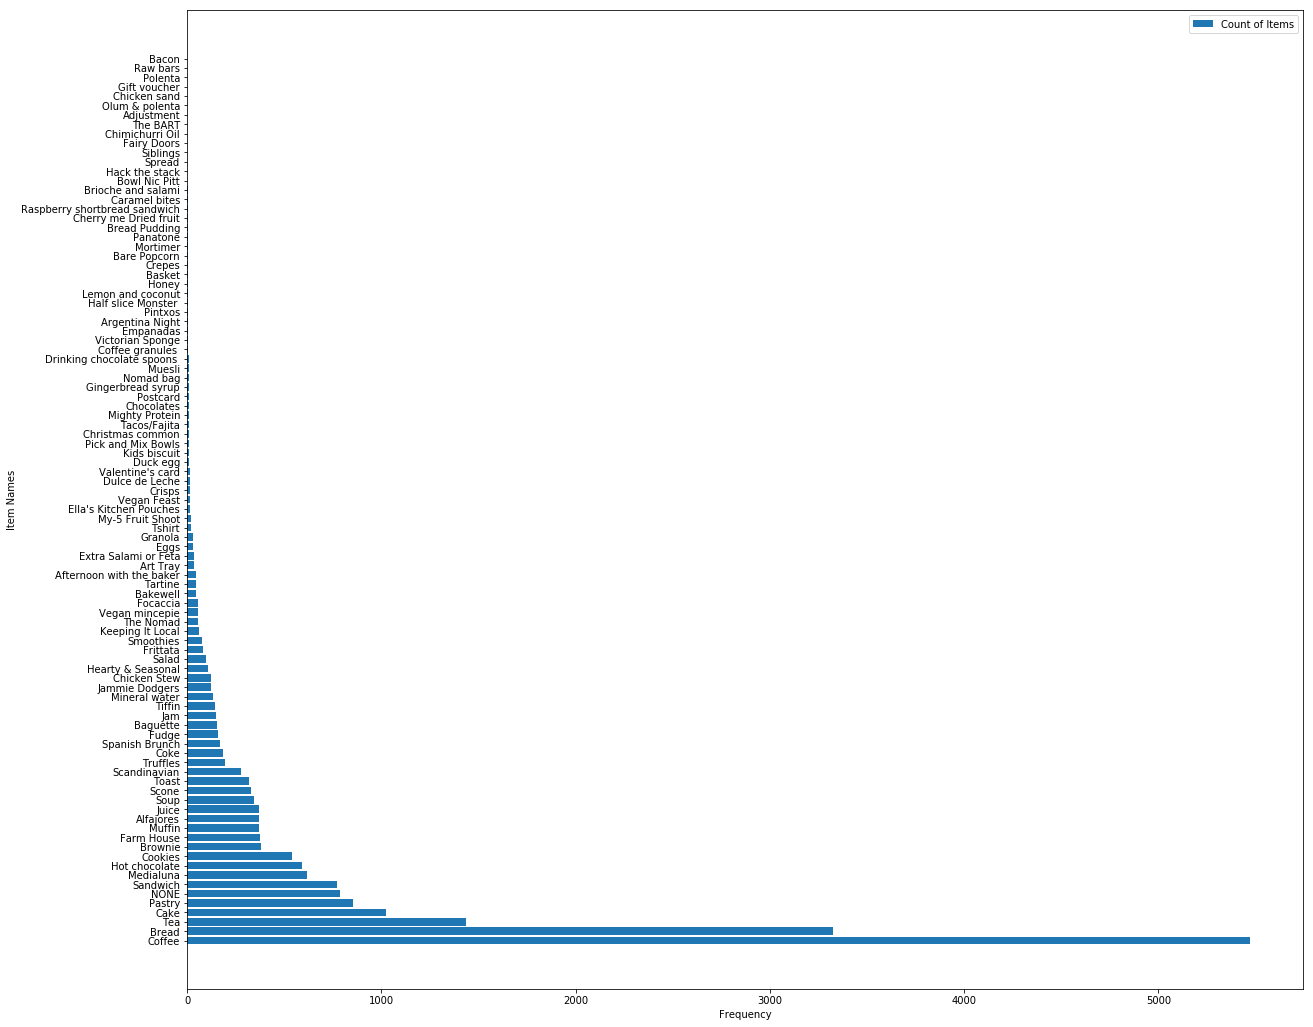

In [7]:
# Frequency of items.Most Popular Item is Coffee Followed By Bread.Correct method for Plotting Legend
item_keys=bakery_data['Item'].value_counts().keys().tolist()
item_values=bakery_data['Item'].value_counts().tolist()
plt.figure(figsize=(20,18))
plt.xlabel("Frequency")
plt.ylabel("Item Names")

plt.barh(item_keys,item_values,label="Count of Items")
plt.legend()


In [8]:
# Finding Baskets based on transaction Numbers

baskets=bakery_data.groupby(["Transaction","Date Time"],as_index=False)

In [9]:
#Most Common Transactions are made for Single Items Only.

'''
Observation:Can Put Special Lane/Counter for single and double items.
Would Make Sense to club offers for single/2 Products as their numbers are high and difference between 2 product
transactions and 3 no transactions is large.
'''

basket_count=baskets['Item'].agg(['count'])['count'].value_counts()
basket_count

1     3474
2     2964
3     1532
4      937
5      360
6      168
7       57
8       25
10       5
9        5
11       3
12       1
Name: count, dtype: int64

In [ ]:
'''Used to combine strings of products into a single list for a given transaction.'''
def testingFunc(x):
    string_joined=','.join(str(e) for e in x)
    list_of_string=string_joined.split(',')
    return list_of_string

cleaned_dataframe=baskets['Item'].agg(lambda x:testingFunc(x))

In [33]:
cleaned_dataframe['Item']=cleaned_dataframe['Item'].values.tolist()

In [34]:
'''Checking What Percentage are Single Transactions and how many constititute combinations.
Most Transactions are for Single Items Only.Can assign a separate counter for single items only.'''

temp=zip(basket_count.keys().tolist(),basket_count.tolist())

one_count=0
two_count=0
above_count=0

for item in temp:    
    if item[0]==1:
        one_count=item[1]
        
    elif item[0]==2:
        two_count=item[1]
    else:
        above_count+=item[1]
        
print((one_count/9531)*100,(two_count/9531)*100,(above_count/9531)*100)

    

36.4494806421152 31.098520616934216 32.451998740950586


In [36]:
# add_datepart(cleaned_dataframe,'Date Time')
cleaned_dataframe.columns
cleaned_dataframe.groupby(['Date TimeYear','Date TimeMonth','Date TimeDayofweek'])['Item']

Most Sale is Done in the month of 2016-11 and 2017-03.Most Popular Day for the Bakery is a Saturday as throughout the 
   entire dataset,the 5th day of the week(Saturday since days are counted from zero.).Owner can have some special events on 
   Saturdays to boost further sales.

In [37]:
'''The Bakery has the 3rd lowest purchases on Sundays.Highest sales are on Saturdays '''
cleaned_dataframe['Date TimeDayofweek'].value_counts()

5    2068
4    1488
6    1264
3    1252
1    1203
0    1135
2    1121
Name: Date TimeDayofweek, dtype: int64

In [85]:
te = TransactionEncoder()
te_ary = te.fit(list(cleaned_dataframe['Item'])).transform(list(cleaned_dataframe["Item"]))
df = pd.DataFrame(te_ary, columns=te.columns_)

In [90]:
'''Apriori Data Formatting Some issue.Will check'''

'Apriori Data Formatting Some issue.Will check'

In [91]:
df

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Support:It tells us that how many times has a item occured in the dataset.(item occurence/total no of items)
Eg:count of coffee./total no of transactions(56%)

In [92]:
apriori(df, min_support=0.1,use_colnames=True)

,support,itemsets
0,0.324940,(Bread)
1,0.103137,(Cake)
2,0.475081,(Coffee)
3,0.141643,(Tea)


In [19]:
??apriori
"Check Later"

'Check Later'

In [89]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.324940,(Bread),1
1,0.103137,(Cake),1
2,0.475081,(Coffee),1
3,0.141643,(Tea),1


In [48]:
bakery_data=pd.read_csv("BreadBasket_DMS.csv")

In [53]:
bakery_data2=bakery_data[bakery_data["Item"]!="NONE"]

bakery_data2

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
5,2016-10-30,10:07:57,3,Cookies
6,2016-10-30,10:08:41,4,Muffin
7,2016-10-30,10:13:03,5,Coffee
8,2016-10-30,10:13:03,5,Pastry
9,2016-10-30,10:13:03,5,Bread


In [39]:
test_df=bakery_data.groupby(['Transaction'])['Item'].apply(list).values.tolist()

# test_df=bakery_data['Item'].astype('category').cat.codes

test_df

[['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna'],
 ['Bread', 'Medialuna', 'Bread', 'NONE'],
 ['Jam', 'Coffee', 'Tartine', 'Pastry', 'Tea'],
 ['Basket', 'Bread', 'Coffee'],
 ['Bread', 'Medialuna', 'Pastry'],
 ['NONE', 'NONE', 'Mineral water', 'Scandinavian'],
 ['Bread', 'Medialuna', 'Coffee'],
 ['Hot chocolate'],
 ['Farm House'],
 ['Farm House', 'Bread'],
 ['Bread', 'Medialuna'],
 ['Coffee', 'Coffee', 'Medialuna', 'Bread'],
 ['Jam'],
 ['Scandinavian', 'Muffin'],
 ['Bread'],
 ['Scandinavian'],
 ['Fudge'],
 ['Scandinavian'],
 ['Coffee', 'Bread'],
 ['Bread', 'Jam', 'NONE'],
 ['Bread'],
 ['Basket'],
 ['Scandinavian', 'Muffin'],
 ['Coffee'],
 ['Coffee', 'Muffin'],
 ['Muffin', 'Scandinavian'],
 ['Tea', 'Bread'],
 ['Coffee', 'Bread', 'NONE'],
 ['Bread', 'Tea'],
 

In [54]:
# test_df

te = TransactionEncoder()

te_ary=te.fit(bakery_data2).transform(bakery_data2)

df = pd.SparseDataFrame(te_ary,columns=te.columns_,default_fill_value=False)

df

,D,I,T,a,c,e,i,m,n,o,r,s,t
0,True,False,False,True,False,True,False,False,False,False,False,False,True
1,False,False,True,False,False,True,True,True,False,False,False,False,False
2,False,False,True,True,True,False,True,False,True,True,True,True,True
3,False,True,False,False,False,True,False,True,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False


In [56]:
apriori(df,min_support=0.1,use_colnames=True)

,support,itemsets
